# Housing Price Predication 

**Objective:** predict prices from structured housing data.

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import pathlib 
import utilities
import preprocessing as prepro
import taylors_pipes as tpipe
import seaborn as sns
import matplotlib.pyplot as plt


from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


def auto_add_project_root(marker = ".git"):
    current_path = pathlib.Path.cwd().resolve()
    for parent in [current_path] + list(current_path.parents):
        # Path object from pathlib behaves well with /
        # / does not do division between Path objects and
        # even between path objects and strings
        if (parent/marker).exists():
            project_root = parent
            sys.path.append(str(project_root)) # for reading in modules
            return project_root
        
    raise RuntimeError(f"Cannot find project root containing {marker}")

project_root= auto_add_project_root()



# How to Read in Data 

# This notebook will not run with the file_path below
# To get a running notebook 
# 1. Download the Kaggle Dataset from https://www.kaggle.com/datasets/austinreese/usa-housing-listings
# 2. Replace csv_file below with your own file name for the downloaded dataset from 1.
# 3. Replace file_path with your own file path to the csv file from step 2.

csv_file = pathlib.Path('housing.csv')
file_path = project_root/csv_file # Windows 


db = pd.read_csv(file_path)


## About the features:

* ``'id'`` - an integer acting as an id number.
* ``'url'`` - the url hosting the listing of the house. 
* ``'region'`` - location of house (usually a city name).
* ``'region_url'`` - the regions craigslist url 
* ``'price'`` - the rent/price *per month* in US dollars for the house.
* ``'type'`` - the type of the house whose values consist of
    - apartment
    - condo
    - house
    - duplex
    - townhouse
    - loft
    - manufactured
    - cottage/cabin
    - flat
    - in-law
    - land
    - assisted living
    
* ``'sqfeet'`` - the square footage of the house.
* ``'beds'`` - the number of bedrooms in the house.
* ``'baths'`` - the number of bathrooms in the house.
* ``'cats_allowed'`` - Boolean indicating whether or not cats are allowed in the house (1 = yes, 0 = no).
* ``'dogs_allowed'`` - Boolean indicating whether or not dogs are allowed in the house (1 = yes, 0 = no).
* ``'smoking_allowed'`` - Boolean indicating whether or not smoking is allowed in the house (1 = yes, 0 = no).
* ``'wheelchair_access'`` - Boolean indicating whether or not the house is wheelchair accessible  (1 = yes, 0 = no).
* ``'electric_vehicle_charge'`` - Boolean indicating whether or not the house is equipped with electric vehicle charge capabilities (1 = yes, 0 = no).
* ``'comes_furnished'`` - Boolean indicating whether or not the house is furnished (1 = yes, 0 = no).
* ``'laundry_options'`` - laundry option available in the house whose values consist of: 
    - w/d in unit
    - w/d hookups
    - laundry on site
    - laundry in bldg
    - nan
    - no laundry on site
* ``'parking_options'`` - parking option available in the house whose values consist of:
    - carport
    - attached garage
    - nan
    - off-street parking
    - detached garage
    - street parking
    - no parking
    - valet parking
* ``'image_url'`` - url that hosts the image of the house.
* ``'description'`` - a description of the house.
* ``'lat'`` - the latitude coordinate for the house.
* ``'long'`` - longitude coordinate for the house.
* ``'state'`` - the state (abbreviated) in which the house resides.

## Goal:

The goal for this project is to predict the price per month (in US dollars) of a house based on its:

* square footage ``'sqfeet'``
* number of beds ``'beds'``
* number of baths ``'baths'``
* housing type ``'type'``
* pet policies ``'cats_allowed'`` and ``'dogs_allowed'``
* smoking policies ``'smoking_allowed'``
* laundry options ``'laundry_options'``
* parking options ``'parking_options'``
* location ``'state'``

Our objective translates into a *regression*  problem. We begin with exploring the data in more depth to gain an understanding on the relationships between the features we have just selected and our target (label) ``price``. 

In [2]:
# Create a copy of our data set
data = db.copy() 
# Select the features that are deemed relavent.
selected_features =['id',
                    'price',
                    'sqfeet', 
                    'beds', 'baths',
                    'type',
                    'cats_allowed',
                    'dogs_allowed',
                    'smoking_allowed',
                    'laundry_options',
                    'parking_options',
                    'long',
                    'lat',
                    'state']

#data = db[selected_features].reset_index(drop = True).set_index('id') Gets rid of original index (if there is one) and sets the 'id' column to be the new index.
data = data[selected_features]
data.describe() # Displays statistical information 

,id,price,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,long,lat
count,3.849770e+05,3.849770e+05,3.849770e+05,384977.000000,384977.000000,384977.000000,384977.000000,384977.000000,383059.000000,383059.000000
mean,7.040982e+09,8.825722e+03,1.059900e+03,1.905345,1.480718,0.726890,0.707918,0.731771,-92.700631,37.233487
std,8.800376e+06,4.462200e+06,1.915076e+04,3.494572,0.618061,0.445557,0.454721,0.443038,16.531980,5.546171
min,7.003808e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-163.894000,-43.533300
25%,7.035979e+09,8.050000e+02,7.500000e+02,1.000000,1.000000,0.000000,0.000000,0.000000,-100.775000,33.454700
50%,7.043320e+09,1.036000e+03,9.490000e+02,2.000000,1.000000,1.000000,1.000000,1.000000,-87.745100,37.647800
75%,7.048426e+09,1.395000e+03,1.150000e+03,2.000000,2.000000,1.000000,1.000000,1.000000,-81.179600,41.138300
max,7.051292e+09,2.768307e+09,8.388607e+06,1100.000000,75.000000,1.000000,1.000000,1.000000,172.633000,102.036000


Here we see some unusual properties in the some our our features columns as well as our target column:

* In the ``'price'`` column there is a minimum value of $\$0$ per month. We will assume instances with a price of $\$0$ per month represent bad data and delete such instances.
* In the ``'price'`` column there is a maximum value of $\$2,768,307,249$ per month(```python data['price'].max()``` to get this exact value). Likely, this is some sort of value error- a good indicator is that the 75th quantile $\$1,395$ per month. We will deal with high values like this via outlier detection. One possible argument is that high values like this may be the total cost of a house rather than the price per month; however, this too is unlikely as $2,768,307,249$ is in the billions.
* In the ``'sqfeet'`` column there is a minimum value of $0 ~\mathrm{ft}^2$. We will assume instances with a square footage of $ 0 ~\mathrm{ft}^2$ represent bad data and delete such instances
* In the ``'sqfeet'`` column there is a maximum value of $ 8388607 ~\mathrm{ft}^2 $. Likely this is some sort of data entry error as a quick google search shows that the house with the largest square footage has $178,926~\mathrm{ft}^2$.
* In the ``'beds'`` column there is a minimum value of $0$ beds. This is certainly possible for studio apartments.
* In the ``'beds'`` column there is a maximum value of $1100$ beds. Likely this represents bad data and such instances will be dealt with via outlier detection.
* In the ``'baths'`` column there is a minimum value of $0$ baths. We will assume instances with $0$ baths represent bad data and delete such instances.
* In the ``'baths'`` column there is a maximum value of $75$ baths. Likely this represents bad data and such instance will be dealt with via outlier detection.

With the limit information displayed by ``.describe()`` the values found in the features ``'cats_allowed'``, ``'dogs_allowed'``, and ``'smoking_allowed'`` make sense while keeping in mind they are one-hot encoded; however, we will study these in more detail soon via histograms and box plots. Before doing so, we run the following code to count the number of na values for each of our selected features

```python
size_idx = data.index.size
for col in data.columns:
    na_col = data[col].isna()
    na_val = na_col.values 
    num_na = na_col.sum()
    
    print(f'{col} contains {num_na} na values. Approximately {num_na/size_idx} values in {col} are na.')
```
```output
price contains 0 na values. Approximately 0.0 values in price are na.
sqfeet contains 0 na values. Approximately 0.0 values in sqfeet are na.
beds contains 0 na values. Approximately 0.0 values in beds are na.
baths contains 0 na values. Approximately 0.0 values in baths are na.
type contains 0 na values. Approximately 0.0 values in type are na.
cats_allowed contains 0 na values. Approximately 0.0 values in cats_allowed are na.
dogs_allowed contains 0 na values. Approximately 0.0 values in dogs_allowed are na.
smoking_allowed contains 0 na values. Approximately 0.0 values in smoking_allowed are na.
laundry_options contains 79026 na values. Approximately 0.20527460082030874 values in laundry_options are na.
parking_options contains 140687 na values. Approximately 0.365442610857272 values in parking_options are na.
long contains 1904 na values. Approximately 0.004987465848694327 values in long are na.
lat contains 1904 na values. Approximately 0.004987465848694327 values in lat are na.
state contains 0 na values. Approximately 0.0 values in state are na.
```
From this we see that ``'laundry_options'``, ``'parking_options'``, ``'long'``, and ``'lat'`` are the only features that contain na values. It is important to note here that values in the ``'laundry_options'`` and ``'parking_options'`` have 7 and 8 unique values, respectively. Moreover, both ``'laundry_options'`` and ``'parking_options'`` contain a ``no laundry on site`` and ``no parking`` value, respectively.

**An assumption**: For handling na values in both ``'laundry_options'`` and ``'parking_options'``, we will replace each na value by ``no laundry on site`` and ``no parking``, respectively. Our reasoning here is that it is a possibility that 'na' was taken to mean 'not available' in these two settings upon creating the listing. 

**An assumption**: We drop instance with na values in ``'long'`` or ``'lat'`` as getting rid of these will not affect the size of our data set too much-- this will only get rid of .498% of our instances (it can be checked that a sample has an na `lat` value if and only the sample has an na `long` value).

In [3]:
# As indicated in the above markdown, we will remove the instances where either 'price', 'sqfeet', 'beds', or 'baths' are zero. 



# Columns with the bad data.
bad_data_columns = ['price', 
                    'sqfeet', 
                    'baths']
# Dictionary containing the columns with bad data as keys whose items are
# thresholds where values less than the threshold are considered bad data in their respective column.

bad_data_to_replace = { 'price' : 200,
                        'sqfeet' : 50,
                        'baths' : 0 } 

for col,thresh in bad_data_to_replace.items():
    col_mask = data[col] < thresh
    data = data[~col_mask]
    
# Check to see if we really did get rid of these zero values 

data.describe()


#Replace na values in 'laundry_options' and 'parking_options' as indicated in the previous markdown.

columns_to_na_replace= {'laundry_options' : 'no laundry on site',
                        'parking_options' : 'no parking'}

# I wrote a pipeline do do this in taylors_pipes.py
# Estimator for pipeline
replace = tpipe.ReplaceNA(columns_to_replacement = columns_to_na_replace) 
data = replace.transform(data) #  Returns a copy of the database with the desired na replacements

#Check to see that we replaced each na value by the intended string (no new values made):

columns_replaced = ['laundry_options','parking_options']


# Making sure we did not add any new values accidentally
for col in columns_replaced:
    new_vals = data[col].unique()
    old_vals = data[col].unique()
    for val in new_vals:
        if val not in old_vals:
            raise ValueError(f'{val} is a new value')
        else:
            pass
        

    
# The above for loop does not raise a ValueError nothing that no new values were added, as desired


# drop na values in 'long' and 'lat'
data.dropna(axis = 0, how = 'any',subset =['long', 'lat'],inplace = True) 

# Next we check that there are no na values

size_idx = data.index.size
for col in data.columns:
    na_col = data[col].isna()
    na_val = na_col.values 
    num_na = na_col.sum()
    
    print(f'{col} contains {num_na} na values. Approximately {num_na/size_idx} values in {col} are na.')

# The output of the above loop shows that there are no na values in our data set 







id contains 0 na values. Approximately 0.0 values in id are na.
price contains 0 na values. Approximately 0.0 values in price are na.
sqfeet contains 0 na values. Approximately 0.0 values in sqfeet are na.
beds contains 0 na values. Approximately 0.0 values in beds are na.
baths contains 0 na values. Approximately 0.0 values in baths are na.
type contains 0 na values. Approximately 0.0 values in type are na.
cats_allowed contains 0 na values. Approximately 0.0 values in cats_allowed are na.
dogs_allowed contains 0 na values. Approximately 0.0 values in dogs_allowed are na.
smoking_allowed contains 0 na values. Approximately 0.0 values in smoking_allowed are na.
laundry_options contains 0 na values. Approximately 0.0 values in laundry_options are na.
parking_options contains 0 na values. Approximately 0.0 values in parking_options are na.
long contains 0 na values. Approximately 0.0 values in long are na.
lat contains 0 na values. Approximately 0.0 values in lat are na.
state contains 0

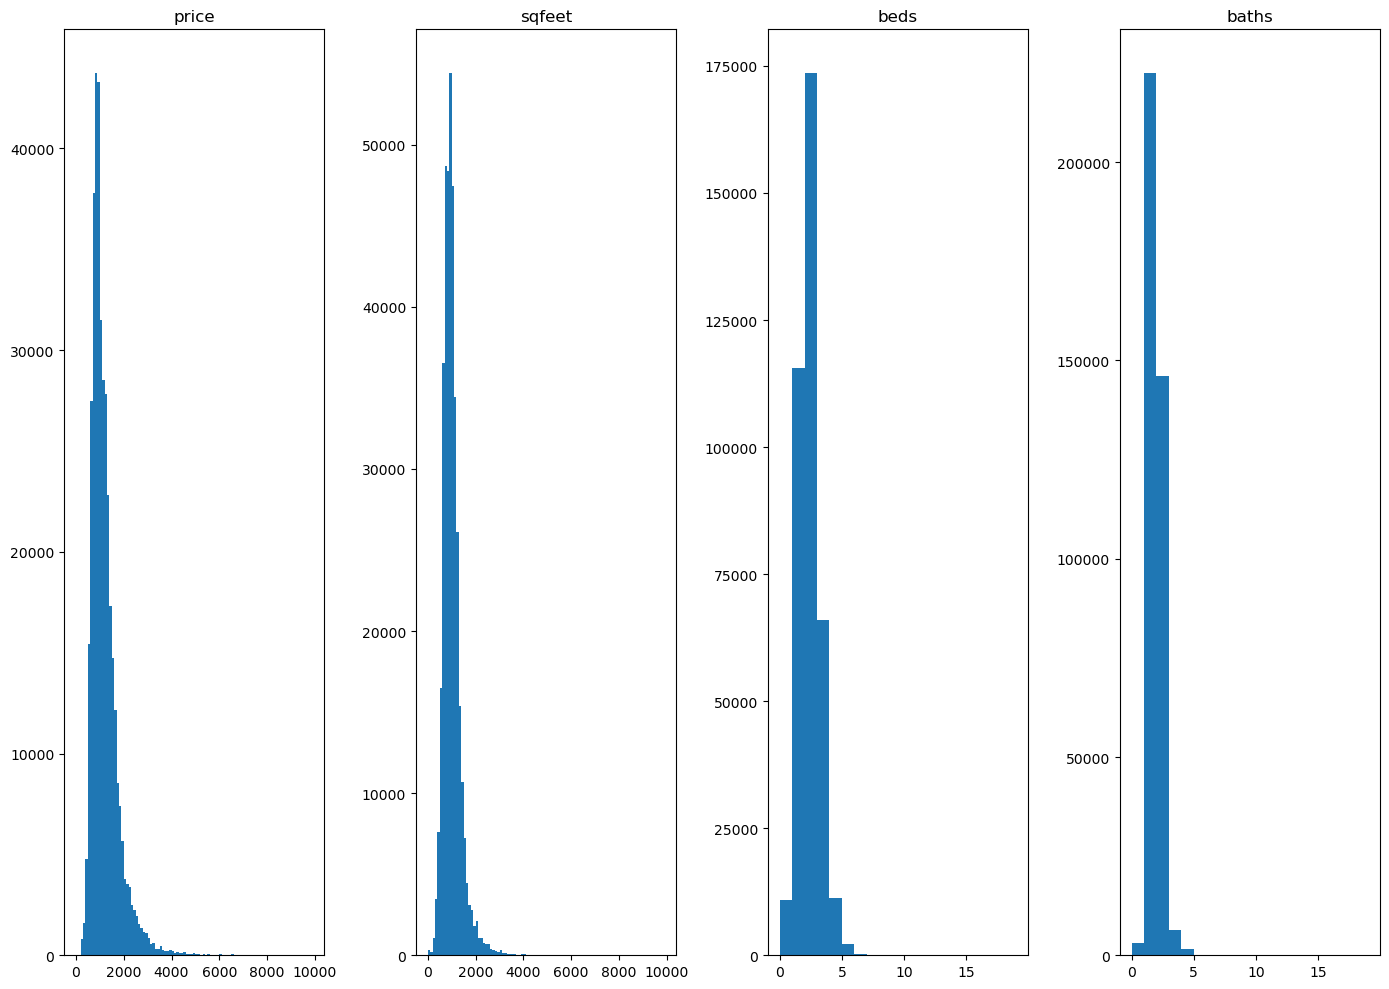

In [4]:
# Some histograms for selected numeric features


# dictionary with selected numeric features as keys whose
# values are the number of bins to be used in their respective
# histograms.
col_to_bins = {'price': [100* i for i in range(0,100)],
                'sqfeet' : [100* i for i in range(0,100)],
                'beds' : [1*i for i in range(0,20)],
                'baths' : [1*i for i in range(0,20)],
                }

# This function takes selected columns from a dataframe together 
# with the number of bins to use for each columns histogram.
# Returns histograms for each selected column. 

def histograms(db : pd.DataFrame, col_to_bins : dict, size : tuple[int,int]):
    chosen_columns = col_to_bins.keys()
    
    n_cols = 4
    n_total = len(chosen_columns)
    n_rows = int(np.ceil(n_total/ n_cols))
    
    fig, ax = plt.subplots(n_rows,n_cols, figsize = size)
    ax = np.atleast_2d(ax) # when row = 1 ensures 2d shape

    for idx, col in enumerate(chosen_columns):
        if col not in col_to_bins.keys(): 
            continue
        
        i,j = divmod(idx, n_cols)
        ax[i,j].hist(db[col], bins = col_to_bins[col])
        ax[i,j].set_title(col)
        
    for k in range(n_total, n_cols*n_rows):
        i,j = divmod(k, n_cols)
        ax[i,j].axis('off')
    
    plt.tight_layout()
    plt.show()
    return
histograms(data, col_to_bins, size =(14,10))
    

## Observations on the histograms:

1) From the above histograms, we see that the data in the `price`, `sqfeet`, `beds`, and `baths` are potentially right-skewed.

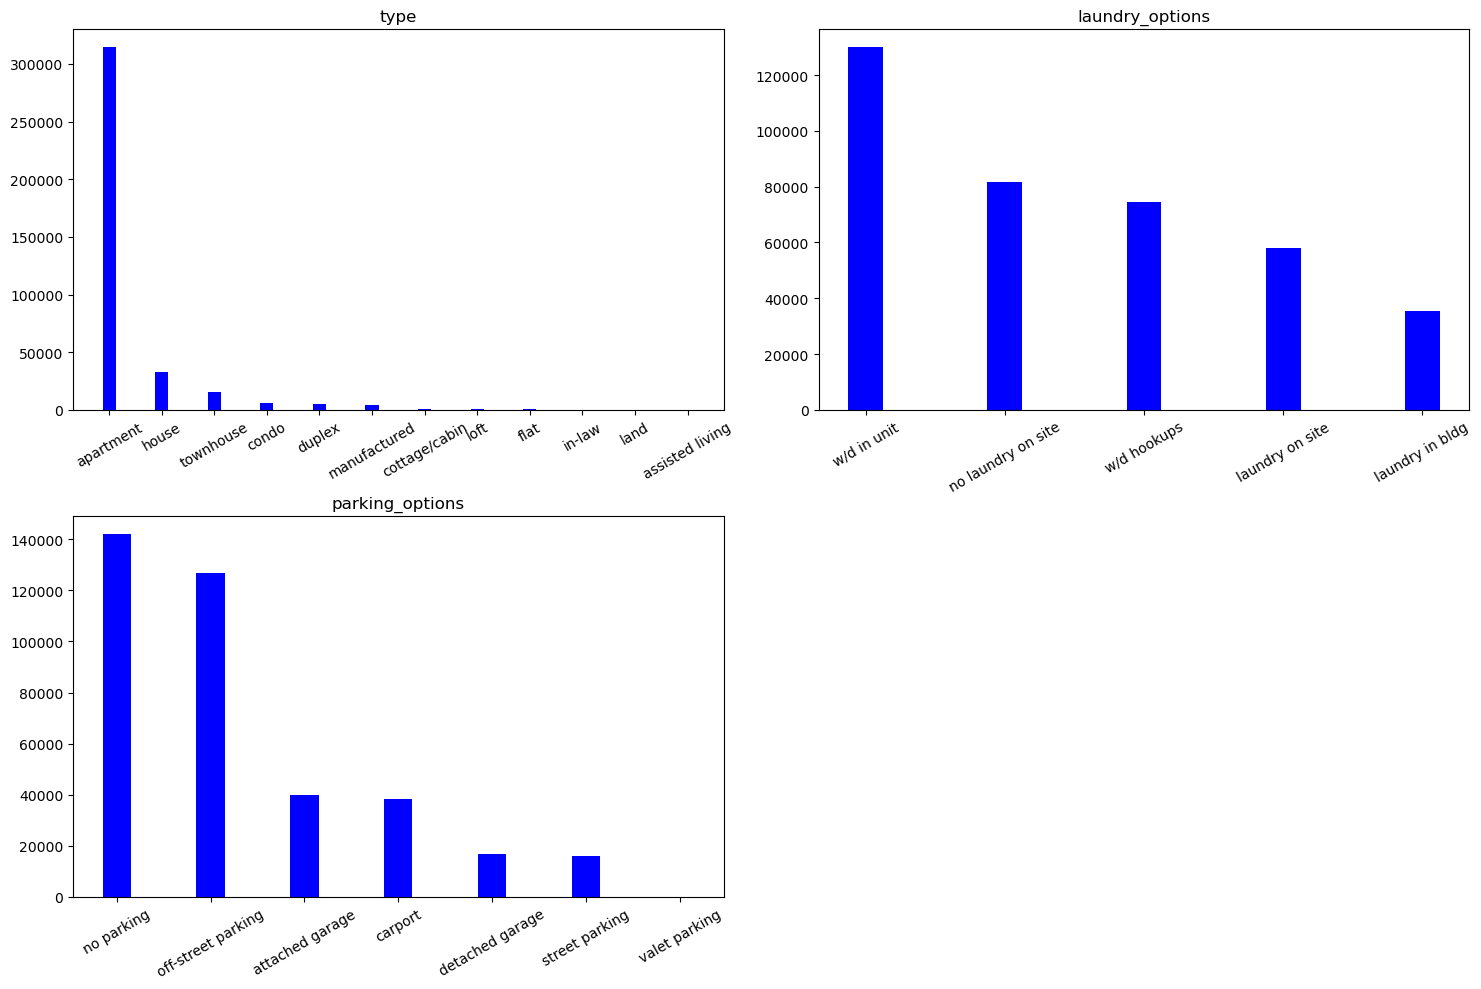

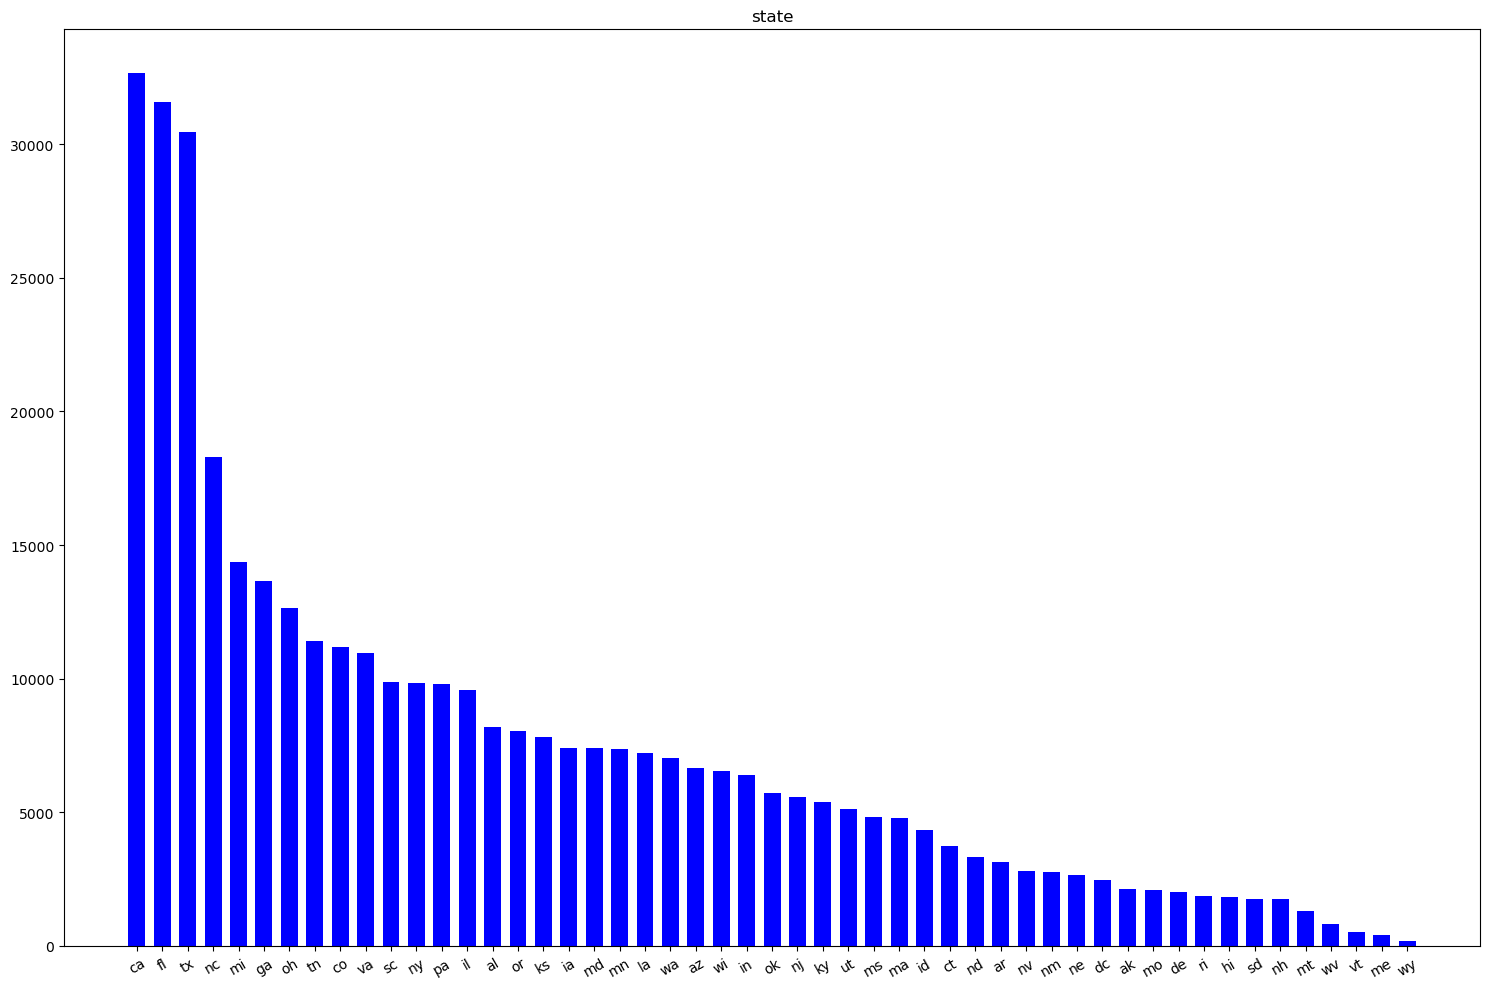

In [5]:
# This function creates a grid of bar charts for specified
# columns as well as parameters to indicate desired visual
# specification to be used for each selected column.

def BarChart(db: pd.DataFrame, n_cols, cols : list[str], col_to_width : dict, col_to_color : dict, tik_scale = 2, tik_rotate = 0, fig_size = (10,10)):
    n_cols = n_cols
    n_total = len(cols)
    n_rows = int(np.ceil(n_total/n_cols))
    fig,ax = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = fig_size)
    ax = np.atleast_2d(ax)

    for idx,col in enumerate(cols):
        to_bar = db[col].value_counts()
        
        
        subjects = to_bar.index
        values = to_bar.values
        tik = np.asarray([i for i in range(len(subjects))]) * tik_scale
        
        
        i,j = divmod(idx,n_cols)
        ax[i,j].bar(tik, values,
                    width = col_to_width.get(col, 0.8), # default width of bars is 0.8
                    color = col_to_color.get(col, 'blue')) #default color of bars is blue
        
        ax[i,j].set_title(col)
        ax[i,j].set_xticks(tik)
        ax[i,j].set_xticklabels(subjects, rotation = tik_rotate)
    
    for k in range(n_total, n_cols * n_rows):
        i,j = divmod(k, n_cols)
        ax[i,j].axis('off')
    plt.tight_layout()
    plt.show()
    return None
    
columns = ['type','laundry_options', 'parking_options']
n_cols =2
col_to_width = {'type':5,'laundry_options' : 5, 'parking_options': 6}
tik_scale = 20
tik_rotate = 30
col_to_color = {'type' : 'blue','laundry_options' : 'blue', 'parking_options' : 'blue'}

BarChart(data, cols= columns, n_cols=n_cols, col_to_width=col_to_width, col_to_color=col_to_color, tik_scale=tik_scale, tik_rotate = tik_rotate, fig_size=(15,10))

    
BarChart(data, cols =['state'], n_cols=1, col_to_width = {'state': 2}, col_to_color = {'state' : 'blue'}, tik_scale = 3,tik_rotate =30, fig_size=(15,10))

A few interesting observations:

1) Most of the house types here are 'apartment'. Since most of the house types are 'apartment', this might be the reason no parking is the most common parking option.
2) Most instances in this data set have a state of California, Florida, or Texas-- a reason for this might be population distribution in the United States. 

** The unequal distribution of states is important to note for doing cross-validation later on in the modeling phase **


c:\Users\tayma\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


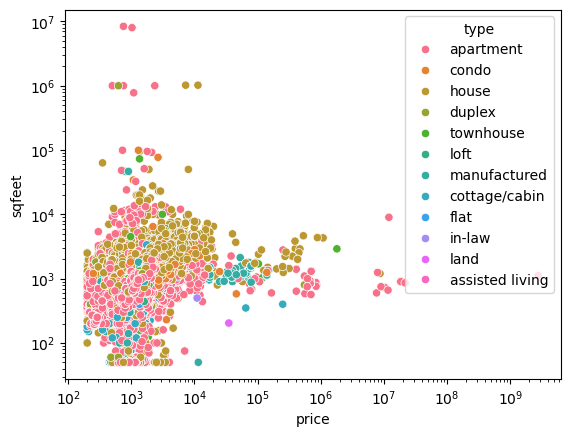

In [6]:
# A scatterplot that shows price vs sqfeet while indicating the type of the house

p =sns.scatterplot(data = data, x ='price', y ='sqfeet', hue = 'type')
p.set_xscale('log')
p.set_yscale('log')
plt.show()


The above scatterplot shows the non-correlated nature of `price` vs `sqfeet`. We verify this with the following visualization of the correlation matrix among our features.

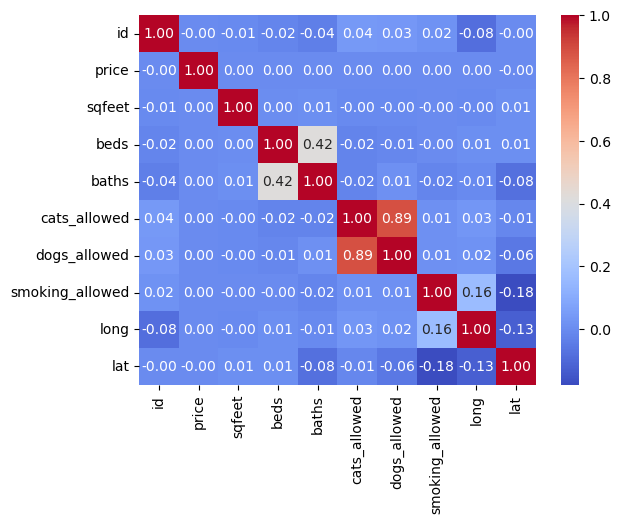

In [7]:
# Correlation matrix 
cor_mat = data.select_dtypes(include = np.number).corr()
# Heat map visualization for correlation matrix.
sns.heatmap(cor_mat, annot = True, cmap = 'coolwarm', fmt =".2f")
plt.title =('Correlation Matrix Heatmap')
plt.show()

The heat map shows that there is little to no correlation between any of our features and the target `price`. There is some correlation between `cats_allowed` and `dogs_allowed`, so if one decides to try linear regression it would be betwe to choose one of these features or combine them.

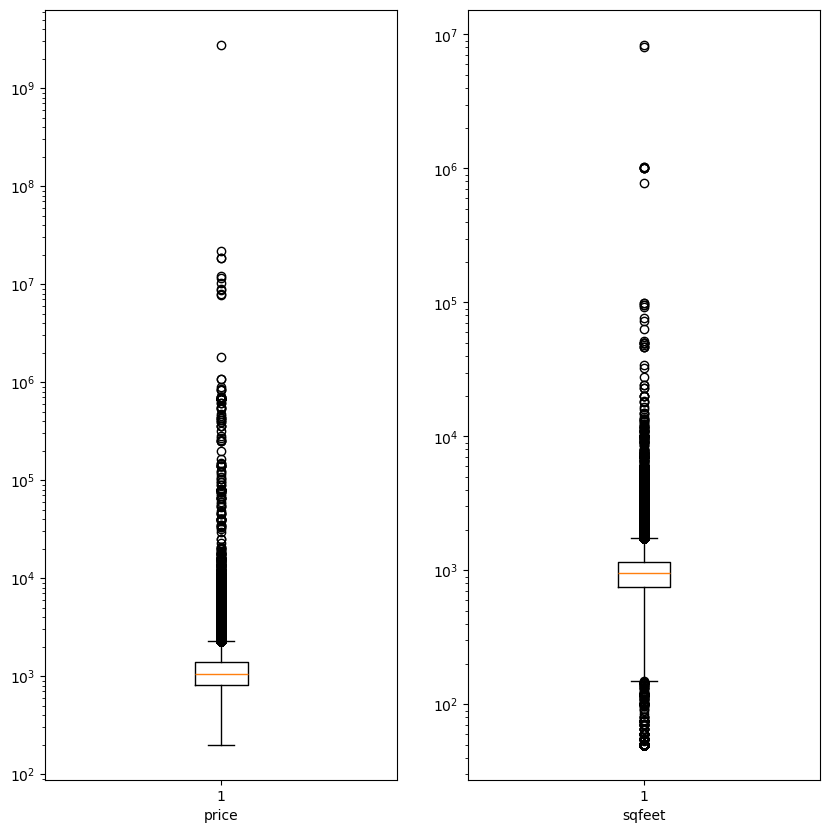

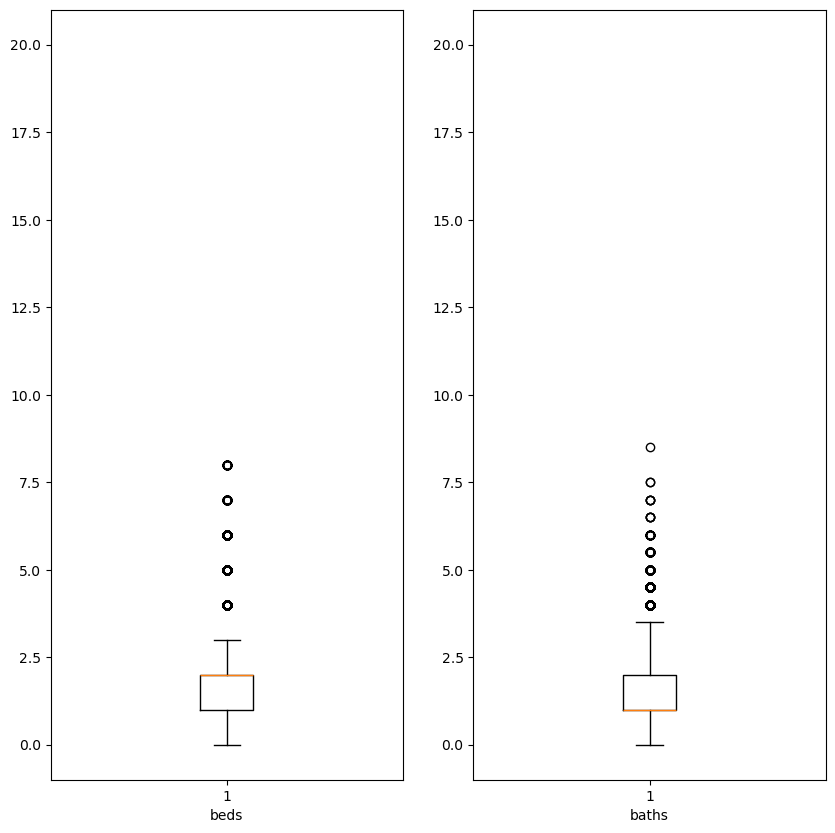

In [8]:
# This function takes in columns and returns 
# a grid of boxplots with visual specifications 
# indicated in the parameters.

def BoxPlots(db : pd.DataFrame, cols : list[str], n_cols: int, y_scale , col_to_yticks : dict = {}, figsize = (10,10), max_min : tuple[int,int] = None):
    
    n_total = len(cols)
    n_rows = int(np.ceil(n_total/n_cols))
    fig, ax = plt.subplots(n_rows, n_cols, figsize= figsize)
    ax = np.atleast_2d(ax)
    for idx, col in enumerate(cols):
        if not pd.api.types.is_numeric_dtype(db[col]):
            raise TypeError(f"dtype of {col} is not numeric")
        i,j = divmod(idx, n_cols)
        
        ax[i,j].boxplot(data[col])
        ax[i,j].set_yscale(y_scale)
        ax[i,j].set_xlabel(col)
        
        if max_min is not None:
            y_min = max_min[0]
            y_max = max_min[1]
            ax[i,j].set_ylim(y_min-1, y_max+1)
        if col in col_to_yticks.keys():
            ax[i,j].set_yticks(col_to_yticks[col])  
    for k in range(n_total, n_rows*n_cols):
        i,j = divmod(k, n_cols)
        ax[i,j].axis('off')
    
    plt.show()
    
columns = ['price','sqfeet']

BoxPlots(data, columns, n_cols =2, y_scale ='log')

columns =['beds','baths']

BoxPlots(data, columns, n_cols =2, y_scale ='linear', max_min=(0,20))


## Observations on the box plots: 

1) There are no *lower* outliers (in terms of the IQR outlier method) for 'price', 'beds' and 'baths'. This is slightly shocking for the 'price' feature. This is certainly less shocking for the 'beds' and 'baths' features.
2) There are plenty of *upper* outliers (in terms of the IQR outlier method) for 'price' and 'sqfeet'. 

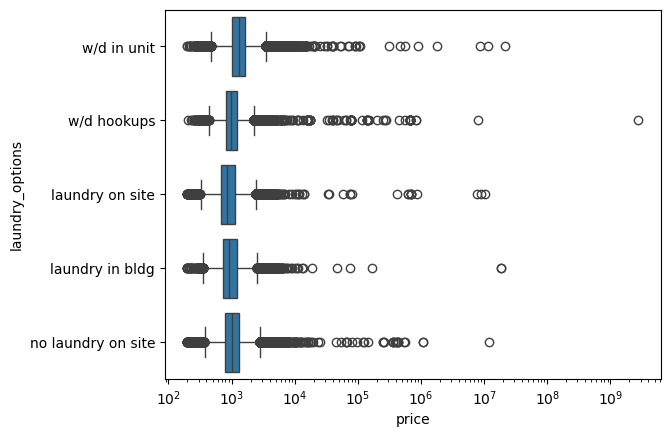

In [9]:
# price vs laundry options boxplot

sns.boxplot(data = data, x='price', y='laundry_options',log_scale = True)
plt.show()


## Observation on 'price' vs 'laundry_options' box plots

1) It is rather odd that the median of the 'price' feature of instance with no laundry on site is larger than that of it's laundry on site and laundry in bldg counterparts.

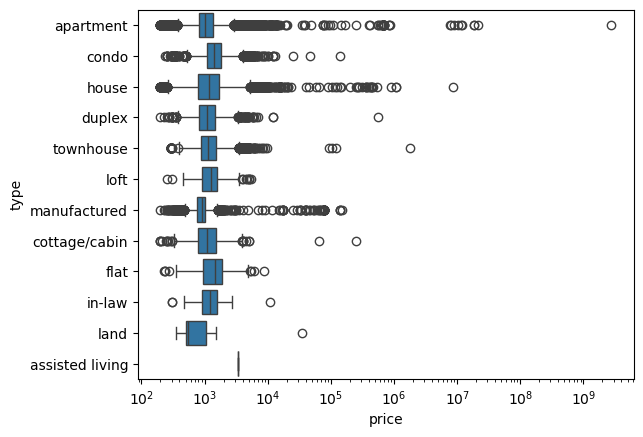

In [10]:
# price vs type boxplot
sns.boxplot(data=data, x= 'price', y='type', log_scale=True)
plt.show()


## Observations about price vs type box plots

1) It is very odd that the instance with the highest maximum price is an apartment. We also keep in mind that this maximum price is in the billions. More than just an outlier this likely represents truly bad data.

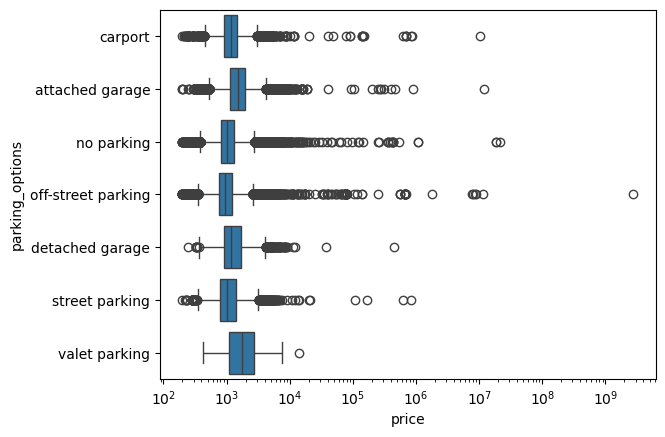

In [11]:
# price vs parking_options boxplot
sns.boxplot(data = data, x ='price', y='parking_options', log_scale = True)
plt.show()

## Observations on 'price' vs 'parking_options' boxplots

1) It is interesting that the price of homes with no parking has a greater median than those of its off-street parking counterpart.

In [12]:


# This function calculates skewness for each numeric column in 
# the inputted dataframe

def skewness(db : pd.DataFrame, bias : bool = False):
    
    db = db.copy()
    db = db.select_dtypes(include= np.number) # Gets rid of nonnumeric columns
    skewdic = dict({})
    for col in db.columns:
        db[col] = db[col].dropna()
        N = db[col].value_counts().sum()
        mean = db[col].mean()
        std = db[col].std()
        g1_series = db[col].map(lambda x : (x-mean)**3)
        skewdic[col] =  (1/N)*(1/std**3) * (g1_series.sum())
        if not bias:
            skewdic[col] = [skewdic[col]]
        elif bias:
            skewdic[col] = [(np.sqrt(N*(N-1)))/(N*(N-2))*skewdic[col]]
        
    skewdb = pd.DataFrame(skewdic)
    skewdb['Skewness'] =['Skewness']
    
    
    return skewdb.set_index('Skewness')

skewness(data)

,id,price,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,long,lat
Skewness,,,,,,,,,,
Skewness,-1.09805,616.095223,407.342544,280.814644,10.293263,-1.030035,-0.923428,-1.047301,-0.042285,0.255261


## Observations on Skewness:
From the 'skewness' table above, we see that 'price', 'sqfeet', 'beds', and 'baths' are heavily right-skewed -- the first three are extremely so. This is an important characteristic to check especially in choosing how we will model price predictions; some models, like linear regression, are very sensitive to skewness. For future note (mostly for myself), to combat right-skewness, one would apply a logarithmic transformation to these features in the pipeline.


## Feature Engineering:

Next we describe the feature engineering to be used in our data pipeline further ahead. 

1. We combine the features ``'cats_allowed'``, ``'dogs_allowed'``, ``'smoking_allowed'`` features by adding their values. Our justification here is that each of these features indicate a lifestyle choice.


2. We will apply a log transform to    ``'sq_feet'``- the reasoning here is that the price of a house typically isn't linear with respect to square footage; instead it increases quickly at the beginning and usually starts to taper off, like a logarithmic curve. We call this new transformed column ``'log_sqfeet'``.

3. We will combine the ``'beds'`` and ``'baths'`` features by adding their values and divide the sum by the value of ``'log_sqfeet'``. Our justification here is that the number of rooms (beds + baths for our purposes) divided by the square footage is an indicator of how the house is laid out. In particular a lower value in this new combined feature indicates that the house has more 'living room' than a higher value, which might be a useful insight. Moreover, it might be a good idea to scale the ``'beds'`` and ``'baths'`` column to higher values so that the resulting new columns values are not small numbers and can be more easily compared.

4. We will hotkey encode ``'type'``, ``'laundry_options'``, ``'parking_options'``, ``'state'``






In [13]:





# Create a copy of data to prevent data leakage.
data = db.copy()

# We select our features here (not in pipeline since we are ignoring columns)

selected_features =['id',
                    'price',
                    'sqfeet', 
                    'beds', 'baths',
                    'type',
                    'cats_allowed',
                    'dogs_allowed',
                    'smoking_allowed',
                    'laundry_options',
                    'parking_options',
                    'long',
                    'lat',
                    'state']

data = data[selected_features]

# Removal of bad values
# Columns with the bad data (might be able to get rid of this)
bad_data_columns = ['price', 
                    'sqfeet', 
                    'baths']

# Dictionary containing the columns with bad data as keys whose items are
# thresholds where values less than the threshold are considered bad data in their respective column.
bad_data_to_replace = { 'price' : 200,
                        'sqfeet' : 50,
                        'baths' : 0 } 

for col,thresh in bad_data_to_replace.items():
    col_mask = data[col] < thresh
    data = data[~col_mask]
    
# IQR Range
# We filter out rows outside the IQR range for each numeric column

data = prepro.IQRFlag(data, disclude = ['id','long','lat'],invert = True,filter = True )

data





,id,price,sqfeet,beds,baths,type,cats_allowed,dogs_allowed,smoking_allowed,laundry_options,parking_options,long,lat,state
0,7049044568,1148,1078,3,2.0,apartment,1,1,0,w/d in unit,carport,-119.796,39.5483,ca
1,7049047186,1200,1001,2,2.0,condo,0,0,0,w/d hookups,carport,-119.789,39.5026,ca
2,7043634882,1813,1683,2,2.0,apartment,1,1,1,w/d in unit,attached garage,-119.708,39.6269,ca
3,7049045324,1095,708,1,1.0,apartment,1,1,1,w/d in unit,carport,-119.771,39.4477,ca
4,7049043759,289,250,0,1.0,apartment,1,1,1,laundry on site,NaN,-119.805,39.5357,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384972,7049053337,1295,957,2,2.0,apartment,1,1,1,w/d in unit,carport,-119.771,39.4477,ca
384973,7049052968,1549,1034,2,2.0,apartment,1,1,0,w/d in unit,NaN,-119.708,39.6269,ca
384974,7049050454,1249,840,2,1.0,apartment,1,1,1,laundry on site,off-street parking,-119.746,39.5358,ca
384975,7049050149,1429,976,2,2.0,apartment,1,1,1,w/d in unit,carport,-119.703,39.5585,ca


In [14]:




data.dropna(axis = 0, how = 'any',subset =['long', 'lat'], inplace = True) # Can change later 

# Split the data into a training set and a test set
# Splits along 'id' column and changes it to the index

split_data = utilities.split(data, id_column = 'id', test_size = 0.2, id_index = True)
test_set, train_set = split_data

# Create a label pd.Series 
y_train = train_set['price']

# Drop label column from training set
X_train = train_set.drop('price', axis =1)
print(X_train)

            sqfeet  beds  baths       type  cats_allowed  dogs_allowed  \
id                                                                       
7049044568    1078     3    2.0  apartment             1             1   
7043634882    1683     2    2.0  apartment             1             1   
7049045324     708     1    1.0  apartment             1             1   
7049043759     250     0    1.0  apartment             1             1   
7046327064     720     1    1.0  apartment             1             1   
...            ...   ...    ...        ...           ...           ...   
7049054520     850     2    1.0  apartment             0             0   
7049053337     957     2    2.0  apartment             1             1   
7049052968    1034     2    2.0  apartment             1             1   
7049050454     840     2    1.0  apartment             1             1   
7049050010     957     2    2.0  apartment             1             1   

            smoking_allowed  laundry_

## A note on Modeling:

We will not do a linear regression since our correlation matrix above shows us that this is likely a fruitless endeavor. One possibility would be to use polynomial regression, in which cases we would apply the `PolynomialFeatures` Pipeline from Scikit-Learn and then perform a linear regression. *We will not* do a polynomial regression either. Though, for future note this can be helpful in conjunction is lasso/elastic net regression to detect features that are not contributing much to the modeling.

A good option is to do a Random Forest Regression, which we initially tried; this was very slow. 

After testing with a Random Forest Regression, we worked with a XGBoost Regressor, which ended up doing quite well (see below).


In [15]:

columns_to_na_replace= {'laundry_options' : 'no laundry on site',
                        'parking_options' : 'no parking'}

estimators = [  ('na_replace', tpipe.ReplaceNA(columns_to_replacement=columns_to_na_replace)),
                ('onehot1', tpipe.OneHotEncode(col = 'parking_options', drop = True)),
                ('onehot2', tpipe.OneHotEncode(col = 'laundry_options', drop = True)),
                ('onehot3', tpipe.OneHotEncode(col = 'type', drop = True)),
                ('onehot4', tpipe.OneHotEncode(col = 'state', drop = True)),
                ('bed*bath', tpipe.ArithmeticTransformer(op ='multiply', new_column_name='bed*bath', columns =['beds', 'baths'])),
                ('bed*bath/sqfeet', tpipe.ArithmeticTransformer(op ='divide', new_column_name = 'bed*bath/sqfeet', columns =['bed*bath', 'sqfeet'])),
                ('bed+bath', tpipe.ArithmeticTransformer(op ='plus', new_column_name='bed+bath', columns =['beds', 'baths'])),
                ('dog+cat+smoke', tpipe.ArithmeticTransformer(op ='plus', new_column_name='dog+cat+smoke', columns =['dogs_allowed', 'cats_allowed', 'smoking_allowed'])),
                ('XGBRegressor', XGBRegressor(n_estimators = 1500, max_depth = 10, learning_rate = .01, subsample=.8,colsample_bytree =.8 ,reg_alpha =.3, reg_lambda = 1))
                ]

model = Pipeline(estimators)

# The following function tracks the following metric scores:
# MSE, RMSE, R^2, and Relative RSME. Also records the models parameters.
def model_tracker(X_train: pd.DataFrame,
                  y_train: pd.Series,
                  model : Pipeline,
                  tracker : pd.DataFrame,
                  X_test : pd.DataFrame = None,
                  y_test : pd.Series = None):

    if X_test is None:
        X_test=X_train
    if y_test is None:
        y_test=y_train
        
    parameters_dict = model.get_params()
    fitted_model = model.fit(X_train,y_train)
    preds = fitted_model.predict(X_test)
    
    ser = pd.Series()
    
    ser['Parameters'] = parameters_dict

    MSE_num = mean_squared_error(preds, y_test)
    RMSE_num = root_mean_squared_error(preds,y_test)
    R2_num = r2_score(preds, y_test)
    ser['MSE'] = MSE_num
    ser['RMSE'] = RMSE_num
    ser['R^2'] = R2_num
    
    
    tracker = pd.concat([tracker, ser.to_frame().T], ignore_index=True )
    return tracker

results =pd.DataFrame()
train_metrics = model_tracker(X_train,y_train,model,tracker = results)

save_to_path = pathlib.Path('metrics/training_metrics.csv')
train_metrics.to_csv(project_root/save_to_path)



In [16]:
display(train_metrics)

,Parameters,MSE,RMSE,R^2
0,"{'memory': None, 'steps': [('na_replace', Repl...",14479.805387,120.332063,0.875808


In [17]:
# Kfold stratify along 'state'

from sklearn.model_selection import StratifiedKFold

# This function performs a Kfold stratification
# along the column (col) parameter.
# Records a list of scores for each fold whose metric is 
# specified in the scoring parameter.
def StratifiedKFold_along_column_metrics(X_train : pd.DataFrame,
                                     y_train : pd.DataFrame,
                                     strat_col:str,
                                     model : Pipeline,
                                     n_splits : int =5,
                                     shuffle : bool =True,
                                     random_state :int =42,
                                     metrics : dict = {'MSE':mean_squared_error,'RMSE':root_mean_squared_error, 'R2':r2_score}):
    skfold = StratifiedKFold(n_splits = n_splits, shuffle= shuffle, random_state = random_state)
    
    across_folds_metric_df=pd.DataFrame() # empty dataframe to be returned
    folds_metrics = dict({}) # holds each folds metrics
    fold_count=0
    for  train_idx, test_idx in skfold.split(X_train, X_train[strat_col]): # to ensure we stratify along a particular column
        fold_count = fold_count + 1
        X_fold_train, X_fold_test = X_train.iloc[train_idx], X_train.iloc[test_idx] # Predictors for each folds training and test sets
        y_fold_train, y_fold_test = y_train.iloc[train_idx], y_train.iloc[test_idx] # Target for each folds training and test sets
    
        fitted = model.fit(X_fold_train,y_fold_train)
        predicts = fitted.predict(X_fold_test)
        for metric_name,metric_func in metrics.items():
            score = metric_func(predicts,y_fold_test)
            folds_metrics['Fold']=fold_count
            folds_metrics[metric_name]=score

        across_folds_metric_df=pd.concat([across_folds_metric_df, pd.DataFrame([folds_metrics])]).reset_index(drop=True)
    
    return across_folds_metric_df
        
    
        #Testing to see if this really does stratify
        #train_dist = X_train[col].value_counts(normalize=True).round(3)
        #test_dist = X_test[col].value_counts(normalize=True).round(3)

        #print(f"\n=== Fold {fold+1} ===")
        #print("Train distribution:\n", train_dist)
        #print("Test distribution:\n", test_dist)
        





In [18]:
# CV Scores
CV_scores = StratifiedKFold_along_column_metrics(X_train,y_train,'state', model= model, n_splits =5, shuffle = True, random_state=42)

In [19]:
save_to_path = pathlib.Path('metrics/CV_scores.csv')
CV_scores.to_csv(project_root/save_to_path)
display(CV_scores)

,Fold,MSE,RMSE,R2
0,1,19360.050293,139.140398,0.829488
1,2,19609.440444,140.033712,0.829407
2,3,19766.164574,140.592192,0.827806
3,4,20000.204920,141.422081,0.825650
4,5,20131.633404,141.885987,0.823806


In [20]:
display(train_metrics)

,Parameters,MSE,RMSE,R^2
0,"{'memory': None, 'steps': [('na_replace', Repl...",14479.805387,120.332063,0.875808


The tables above shows that MSE, RSME, and $R^2$ metrics have little variance across folds. As MSE and RSME are not scale independent, we focus on the $R^2$ metric for analysis of over/underfitting. With this in mind, the tables above shows an absolute difference of roughly .05 in $R^2$ values between our training $R^2$ and the average of $R^2$ across our CV folds. Therefore, our model is not significantly overfitting the training data.

In [21]:
y_test = test_set['price']
X_test = test_set.drop(columns=['price'])
tracker=pd.DataFrame()
final_test_results = model_tracker(X_train= X_train,
              y_train=y_train,
              model=model,
              X_test=X_test,
              y_test=y_test,
              tracker=tracker)

display(final_test_results)

,Parameters,MSE,RMSE,R^2
0,"{'memory': None, 'steps': [('na_replace', Repl...",19902.602478,141.076584,0.82307


The tables above shows an absolute difference of roughly .05 in $R^2$ values between our training $R^2$ and the test $R^2$. Therefore, our model is not significantly overfitting the training data and extends well to unseen data. Interestingly, our test $R^2$ is extremely close to the $R^2$ scores across our training CV folds above. 

Our final models $R^2$ score indicates that the model accounts for approximately 82.31% of the total variation in housing price for this data set.

In [22]:
save_to_path = pathlib.Path('metrics/final_metrics.csv')
final_test_results.to_csv(project_root/save_to_path)